In [1]:
%matplotlib inline
import os
import flow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='darkgrid')
from IPython.display import clear_output
import pandas as pd
import cascade as cas

In [1]:
import cascade as cas
cas.plotting.plt.xdayheatmap('OA27', cell_id=range(184,1556), trace_type='zscore', vmax=3, vmin=-3)

[-1.         -0.93544222 -0.87088444 -0.80632666 -0.74176888 -0.6772111
 -0.61265332 -0.54809554 -0.48353776 -0.41897998 -0.3544222  -0.28986442
 -0.22530664 -0.16074886 -0.09619108 -0.0316333   0.03292448  0.09748226
  0.16204004  0.22659782  0.2911556   0.35571338  0.42027116  0.48482894
  0.54938672  0.6139445   0.67850228  0.74306006  0.80761784  0.87217562
  0.9367334   1.00129119  1.06584897  1.13040675  1.19496453  1.25952231
  1.32408009  1.38863787  1.45319565  1.51775343  1.58231121  1.64686899
  1.71142677  1.77598455  1.84054233  1.90510011  1.96965789  2.03421567
  2.09877345  2.16333123  2.22788901  2.29244679  2.35700457  2.42156235
  2.48612013  2.55067791  2.61523569  2.67979347  2.74435125  2.80890903
  2.87346681  2.93802459  3.00258237  3.06714015  3.13169793  3.19625571
  3.26081349  3.32537127  3.38992905  3.45448683  3.51904461  3.58360239
  3.64816017  3.71271795  3.77727573  3.84183351  3.90639129  3.97094907
  4.03550685  4.10006463  4.16462241  4.22918019  4.

KeyboardInterrupt: 

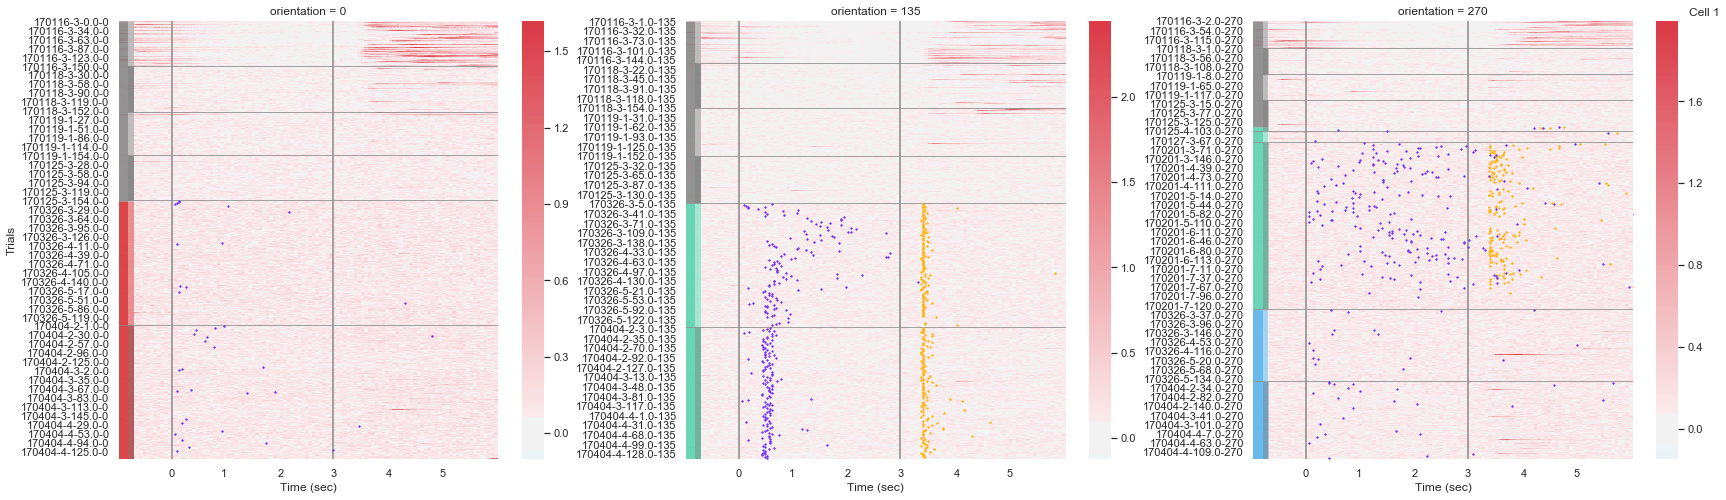

In [11]:
mouse = 'OA27'
cell_id=None
trace_type='dff'
cs_bar=True
day_bar=True
day_line=True
run_line=False
match_clim=True
vmin=None
vmax=None
smooth=False
verbose=True

def _myheatmap(data, **kwargs):
    """ Helper function for FacetGrid heatmap."""

    mydata = data.set_index('orientation', append=True)
    sns.heatmap(mydata, **kwargs)
    
    """ Create heatmap of each cell aligned across time.

Parameters:
-----------
mouse : str; mouse name
trace_type : str; dff, zscore, deconvolved
cs_bar : logical; add a bar to match cs on edge of plot
day_bar : logical; add checkerboard to match days on cs bar
day_line : logical; add a lines between days
run_line : logical; ddd lines between runs
Returns:
________
Saves figures to .../analysis folder
"""

# arthur's predetermined hex colors
colors = {
    'orange': '#E86E0A',
    'red': '#D61E21',
    'gray': '#7C7C7C',
    'black': '#000000',
    'green': '#75D977',
    'mint': '#47D1A8',
    'purple': '#C880D1',
    'indigo': '#5E5AE6',
    'blue': '#47AEED',  # previously 4087DD
    'yellow': '#F2E205',
}

# cs to color mapping
cs_colors = {
    'plus': 'mint',
    'minus': 'red',
    'neutral': 'blue',
    'pavlovian': 'mint',
    'naive': 'gray'
}

# checkerboard overlay or day_bar
day_colors = {
     'A': '#FDFEFE',
     'B': '#7B7D7D'
}

# red=high, white=middle, blue=low colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# load metadata
save_dir = os.path.join(flow.paths.outd, str(mouse))
meta_path = os.path.join(save_dir, str(mouse) + '_df_trialmeta.pkl')
dfm = pd.read_pickle(meta_path)

# create a binary map of every day a cell is present
xmap = cas.df.get_xdaymap('OA27')

# set up range conditonal on input
if cell_id is None:
    cell_range = range(1, np.shape(xmap)[0]+1)
else:
    cell_range = cell_id

# loop through cells and plot
for cell_idx in cell_range:

    # create single cell df
    dft = cas.df.singlecell(mouse, trace_type, cell_idx, xmap=xmap)
    dft = dft.reset_index(level=['cell_idx', 'timestamp'])

    # filter metadata trials before merging
    trial_indexer = (((dfm.orientation == 0) | (dfm.orientation == 135) | (dfm.orientation == 270))
                     & ((dfm.tag == 'standard') | (dfm.tag == 'learning_start') | (dfm.tag == 'reversal1_start')
                     | (dfm.tag == 'reversal2_start'))
                     & ((dfm.condition == 'plus') | (dfm.condition == 'minus') | (dfm.condition == 'neutral'))
                     & (dfm.hunger == 'hungry'))
    dfm = dfm.loc[trial_indexer, :]

    # merge on filtered trials
    dff = pd.merge(dft, dfm, on=['mouse', 'date', 'run', 'trial_idx'], how='inner')
    
    # smooth signal with rolling 3 unit window
    if smooth:
        dff['trace'] = dff['trace'].rolling(3).mean()
    
    # get timestamp info for plotting lines
    times = np.unique(dff['timestamp'])
    print(times)
    zero_sec = np.where(times <= 0)[0][-1]
    three_sec = np.where(times <= 3)[0][-1]

    # oris
    oris = np.array([0, 135, 270])

    # plot main figure
    toplot = dff.pivot_table(index=['date', 'run','trial_idx','orientation'],
                            columns='timestamp', values='trace')
    g = sns.FacetGrid(toplot.reset_index('orientation'), col='orientation',
                      height=8, sharey=False, dropna=False)
    g.map_dataframe(_myheatmap, vmax=vmax, vmin=vmin, center=0, cmap=cmap)
    g.fig.suptitle('Cell ' + str(cell_idx), x=0.98)

    # loop through axes and plot relevant metadata on top
    count = 0
    cmin = []
    cmax = []
    ccmap = []
    for ax in g.axes[0]:

        # match vmin and max across plots (first check values)
        if match_clim and vmax is None:
            vmin, vmax = ax.collections[0].get_clim()
            cmin.append(vmin)
            cmax.append(vmax)
            ccmap.append(ax.collections[0].get_cmap())

        # get metadata for this orientation/set of trials
        meta = dff.loc[dff['orientation'] == oris[count], ['condition',
                       'ensure', 'quinine', 'firstlick', 'run_type']]
        meta = meta.reset_index()
        meta = meta.drop_duplicates()
        ensure = np.array(meta['ensure'])
        quinine = np.array(meta['quinine'])
        firstlick = np.array(meta['firstlick'])
        css = meta['condition']
        run_type = meta['run_type']

        ori_inds = np.array(toplot.index.get_level_values('orientation'))
        ori_inds = ori_inds == oris[count]

        # set labels
        if count == 0:
            ax.set_ylabel('Trials')
        ax.set_xlabel('Time (sec)')

        # plot cs color bar/line
        if cs_bar:
            css[run_type == 'naive'] = 'naive'
            for cs in np.unique(css):
                cs_line_color = colors[cs_colors[cs]]
                cs_y = np.where(css == cs)[0]
                cs_y = [cs_y[0]-0.5, cs_y[-1]+0.5]
                ax.plot((2, 2), cs_y, color=cs_line_color, ls='-',
                        lw=15, alpha=0.8, solid_capstyle='butt')

        # find days where learning or reversal start
        if day_bar:
            days = np.array(toplot.index.get_level_values('date'))
            days = days[ori_inds]
            runs = np.array(toplot.index.get_level_values('run'))
            runs = runs[ori_inds]
            count_d = 0
            for day in np.unique(days):
                day_y = np.where(days == day)[0]
                day_y = [day_y[0]-0.5, day_y[-1]+0.5]
                day_bar_color = day_colors[sorted(day_colors.keys())[count_d%2]]
                ax.plot((3.5, 3.5), day_y, color=day_bar_color, ls='-',
                        lw=6, alpha=0.4, solid_capstyle='butt')
                count_d = count_d + 1

        # get limits for plotting
        y_lim = ax.get_ylim()
        x_lim = ax.get_xlim()

        # plot lines between days
        if day_line:
            days = np.array(toplot.index.get_level_values('date'))
            days = days[ori_inds]
            days = np.diff(days)
            day_ind = np.where(days > 0)[0]
            for y in day_ind:
                day_y = [y, y]
                ax.plot(x_lim, day_y, color='#8e8e8e', ls='-', lw=1, alpha=0.8)

        # plot lines between runs
        if run_line:
            runs = np.array(toplot.index.get_level_values('run'))
            runs = runs[ori_inds]
            runs = np.diff(runs)
            run_ind = np.where(runs > 0)[0]
            for y in run_ind:
                run_y = [y, y]
                ax.plot(x_lim, run_y, color='#bababa', ls='-', lw=1,  alpha=0.8)

        # plot onset/offest lines
        ax.plot((zero_sec, zero_sec), y_lim, color='#8e8e8e', ls='-', lw=2, alpha=0.8)
        ax.plot((three_sec, three_sec), y_lim, color='#8e8e8e', ls='-', lw=2, alpha=0.8)

        # plot quinine
        for l in range(len(quinine)):
            if np.isfinite(quinine[l]):
                x = [quinine[l], quinine[l]]
                y = [l, l]
                ax.plot(x, y, color='#0fffc3', ls='', marker='.', markersize=2)

        # plot ensure
        for l in range(len(ensure)):
            if np.isfinite(ensure[l]):
                x = [ensure[l], ensure[l]]
                y = [l, l]
                ax.plot(x, y, color='#ffb30f', ls='', marker='.', markersize=2)

        # plot licks
        for l in range(len(firstlick)):
            if np.isfinite(firstlick[l]):
                x = [firstlick[l], firstlick[l]]
                y = [l, l]
                ax.plot(x, y, color='#7237f2', ls='', marker='.', markersize=2)

        # reset ylabels
        if y_lim[0] < 100:
            step = 10
        elif y_lim[0] < 200:
            step = 20
        elif y_lim[0] < 500:
            step = 50
        elif y_lim[0] < 5000:
            step = 500
        elif y_lim[0] < 10000:
            step = 1000
        elif y_lim[0] >= 10000:
            step = 5000
        base_yticks = range(int(y_lim[-1]), int(y_lim[0]), int(step))
        base_yticks = [s for s in base_yticks]
        base_ylabels = [str(s) for s in base_yticks]

        dates = np.array(toplot.index.get_level_values('date'))
        dates = dates[ori_inds]
        date_yticks = []
        date_label = []

        date_rel = flow.DateSorter.frommeta(mice=[mouse])
        date_rel = [s.date for s in date_rel]

        for day in np.unique(dates):

            # find number of inds needed to shift labels to put in middle of date block
            last_ind = np.where(dates == day)[0][-1]
            first_ind = np.where(dates == day)[0][0]
            shifter = np.round((last_ind - first_ind)/2)
            label_ind = last_ind - shifter

            # get your relative day number
            day_val = np.where(date_rel == day)[0][0] + 1  # add one to make it one-indexed

            # add a pad to keep labels left-justified
            if day_val < 10:
                pad = '  '
            else:
                pad = ''

            # if the date label and trial label inds are exactly the same
            # force the label info onto one line of text
            # label days with imaging day number
            if np.isin(label_ind, base_yticks):
                # remove the existing ind and add a special label to end
                good_tick = ~np.isin(base_yticks, label_ind)
                base_yticks = [base_yticks[s] for s in range(len(good_tick))
                               if good_tick[s]]
                base_ylabels = [base_ylabels[s] for s in range(len(good_tick))
                               if good_tick[s]]
                dpad = '          '
                dpad = dpad[0:(len('          ') - len(str(label_ind)*2))]
                base_ylabels.append('Day ' + str(day_val) + dpad + str(label_ind))
            else:
                base_ylabels.append('Day ' + str(day_val) + '          ' + pad)
            base_yticks.append(label_ind)
        
        # set xticks
        xticklabels = np.array([-1, 0, 1, 2, 3, 4, 5, 6])
        xticklabels = xticklabels[(xticklabels > times[0]) & (xticklabels < times[-1])]
        xticks = [np.where(times <= s)[0][-1] for s in xticklabels]
        print(xticks)
        print(xticklabels)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels, rotation='horizontal')

        count = count + 1

    # match vmin and max across plots (using cmax to choose cmap and cmin)
    if match_clim and vmax is None:
        max_ind = np.nanargmax(cmax)
        cmin = cmin[max_ind]
        cmax = cmax[max_ind]
        ccmap = ccmap[max_ind]

        for ax in g.axes[0]:
            ax.collections[0].set_clim(vmax=cmax, vmin=cmin)
            ax.collections[0].set_cmap(ccmap)

    # save figures into folder structure
    save_dir = os.path.join(flow.paths.graphd, str(mouse))
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    save_dir = os.path.join(save_dir, 'heatmaps ' + str(trace_type))
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    path = os.path.join(save_dir, str(mouse) + '_cell_' + str(cell_idx) + '_' + trace_type + '.png')
    print('Cell: ' + str(cell_idx) + ': done.')
    g.savefig(path)

    if not verbose:
        plt.close()

In [2]:
# Load your triggered traces and corresponding metadata 
mouse = 'OA27'
trace_type = 'dff'
days = flow.DateSorter.frommeta(mice=[mouse])

# load metadata
meta_path = os.path.join(flow.paths.outd, mouse + '_df_' + trace_type + '_trialmeta.pkl')
dfm = pd.read_pickle(meta_path)

# build crossday matrix to use for efficient loading/indexing
# cell_mat = []
# cell_vec = []
# for day in days:
#     cell_ids = flow.xday._read_crossday_ids(day.mouse, day.date)
#     cell_ids = [int(s) for s in cell_ids]
#     cell_mat.append(cell_ids)
#     cell_vec.extend(cell_ids)
# all_cells = np.unique(cell_vec)

# cell_map = np.zeros((len(all_cells),len(days)))
# for day_num in range(len(days)):
#     for cell_num in range(len(all_cells)):
# #         print(np.isin(cell, cell_mat[day_num]))
#         if np.isin(all_cells[cell_num], cell_mat[day_num]):
#             cell_map[cell_num, day_num] = 1

# plt.figure(figsize=(12,100))
# plt.imshow(cell_map)

# Build an xday matrix to ensure no wasted loading
# Use this to determine number of days to iterate through per cell
xmap = cas.df.get_xdaymap('OA27')

dft = cas.df.singlecell(mouse, trace_type, 46, xmap=xmap)
print(dft.head())

# cell_num = 8
# print(np.where(xmap[cell_num,:])[0])
# # load all dfs that contain the cell of interest
# cell_xday = []
# for d in np.where(xmap[cell_num,:] == 1)[0]:
#     print(d)
#     cell_id = cell_num + 1
#     path = os.path.join(flow.paths.outd, str(days[d].mouse) + '_'
#                         + str(days[d].date) + '_df_' + trace_type + '.pkl')
#     dft = pd.read_pickle(path)
#     cell_indexer = dft.index.get_level_values('cell_idx') == cell_id
#     dft = dft.loc[cell_indexer,:]
#     cell_xday.append(dft)
    
# dft = pd.concat(cell_xday)
# dft.head()
# loop through dates and load 
# trig_path = os.path.join(flow.paths.outd, str(days[15].mouse) + '_' + str(days[15].date) + '_df_' + trace_type + '.pkl')
# trig_path2 = os.path.join(flow.paths.outd, str(days[16].mouse) + '_' + str(days[16].date) + '_df_' + trace_type + '.pkl')
# dfm = pd.read_pickle(meta_path)
# dft = pd.read_pickle(trig_path)
# dft2 = pd.read_pickle(trig_path2)


                                                  trace
mouse date   run trial_idx cell_idx timestamp          
OA27  170116 2   0         46       -1.000000 -0.009399
                                    -0.967742  0.132693
                                    -0.935484  0.081996
                                    -0.903226  0.164460
                                    -0.870968 -0.038921


In [10]:
dfm.head()

condition  ensure  firstlick  hunger  \
mouse date   run trial_idx                                               
OA27  170116 2   0          orientation_315     NaN        NaN  hungry   
                 1           orientation_90     NaN        NaN  hungry   
                 2          orientation_270     NaN        NaN  hungry   
                 3           orientation_90     NaN        NaN  hungry   
                 4          orientation_225     NaN        NaN  hungry   

                            orientation  quinine run_type  speed  \
mouse date   run trial_idx                                         
OA27  170116 2   0                  315      NaN    naive    NaN   
                 1                   90      NaN    naive    NaN   
                 2                  270      NaN    naive    NaN   
                 3                   90      NaN    naive    NaN   
                 4                  225      NaN    naive    NaN   

                                            tag  trialerror  
mouse date   run trial_idx                                   
OA27  170116 2   0          orientation_mapping           1  
                 1          orientation_mapping           1  
                 2          orientation_mapping           1  
                 3          orientation_mapping           1  
                 4          orientation_mapping           1

In [3]:
# df = pd.concat([dft, dft2])
# print(dfm.head())
trial_indexer = (((dfm.orientation == 0) | (dfm.orientation == 135) | (dfm.orientation == 270))
                 & ((dfm.tag == 'standard') | (dfm.tag == 'learning_start') | (dfm.tag == 'reversal1_start')
                 | (dfm.tag == 'reversal2_start'))
                 & ((dfm.condition == 'plus') | (dfm.condition == 'minus') | (dfm.condition == 'neutral'))
                 & (dfm.hunger == 'hungry'))
# print(trial_indexer[2])
# test = [((dfm['orientation'] == 0) | (dfm['orientation'] == 135) | (dfm['orientation'] == 270))
#               & ((dfm['tag'] == 'standard') | (dfm['tag'] == 'learning_start') | (dfm['tag'] == 'reversal1_start')
#               | (dfm['tag'] == 'reversal2_start'))
#               & ((dfm['condition'] == 'plus') | (dfm.condition == 'minus') | (dfm.condition == 'neutral'))
#               & (dfm.hunger == 'hunger')]

dfm = dfm.loc[trial_indexer,:]

print(dfm.head())

                           condition  ensure  firstlick  hunger  orientation  \
mouse date   run trial_idx                                                     
OA27  170116 3   0              plus     NaN        NaN  hungry            0   
                 1           neutral     NaN        NaN  hungry          135   
                 2             minus     NaN        NaN  hungry          270   
                 3              plus     NaN        NaN  hungry            0   
                 4           neutral     NaN        NaN  hungry          135   

                            quinine run_type  speed       tag  trialerror  
mouse date   run trial_idx                                                 
OA27  170116 3   0              NaN    naive    NaN  standard           1  
                 1              NaN    naive    NaN  standard           2  
                 2              NaN    naive    NaN  standard           4  
                 3              NaN    naive    NaN  standa

In [25]:
print(dft.head())

                                                  trace
mouse date   run trial_idx cell_idx timestamp          
OA27  170116 2   0         9        -1.000000  0.158136
                                    -0.967742  0.006125
                                    -0.935484  0.867014
                                    -0.903226  0.852613
                                    -0.870968  0.243914


In [4]:
# merge your dataframes on trial_idx
# print(df_m.head())
dft = dft.reset_index(level=['cell_idx', 'timestamp'])
print(dft.head())

                            cell_idx  timestamp     trace
mouse date   run trial_idx                               
OA27  170116 2   0                46  -1.000000 -0.009399
                 0                46  -0.967742  0.132693
                 0                46  -0.935484  0.081996
                 0                46  -0.903226  0.164460
                 0                46  -0.870968 -0.038921


In [5]:
# merge your dataframes on trial_idx
df = pd.merge(dft, dfm, on=['mouse', 'date', 'run', 'trial_idx'], how='inner')

In [32]:
# filter your merged df to only include the trial types you want to be dealing with
# df1 = df.loc[((df.orientation == 0) | (df.orientation == 135) | (df.orientation == 270))
#              & ((df.tag == 'standard') | (df.tag == 'learning_start') | (df.tag == 'reversal1_start')) 
#              & (df.cell_idx == 9),:]
df['condition'].unique()

array(['plus', 'neutral', 'minus'], dtype=object)

In [23]:
# remove nan trials 
# df1 = df1.loc[np.isfinite(df1.trace),:]
# print(np.sum(np.isnan(df1['trace'])))
# np.unique(df['cell_idx']) #2,    3,    4,    9,   10,   13,   15,   17,   29,   30,   31,
# df1.head()
def myheatmap(data, **kwargs):
    
#     print(data.head())
    mydata = data.set_index('orientation', append=True)
    print(np.shape(mydata))
    print(len(mydata.index.get_level_values('orientation')))
#     print(mydata.head())
    sns.heatmap(mydata, **kwargs)

(397, 217)
397
(430, 217)
430
(1137, 217)
1137
397
(397.0, 0.0)
430
(430.0, 0.0)
1137
(1137.0, 0.0)


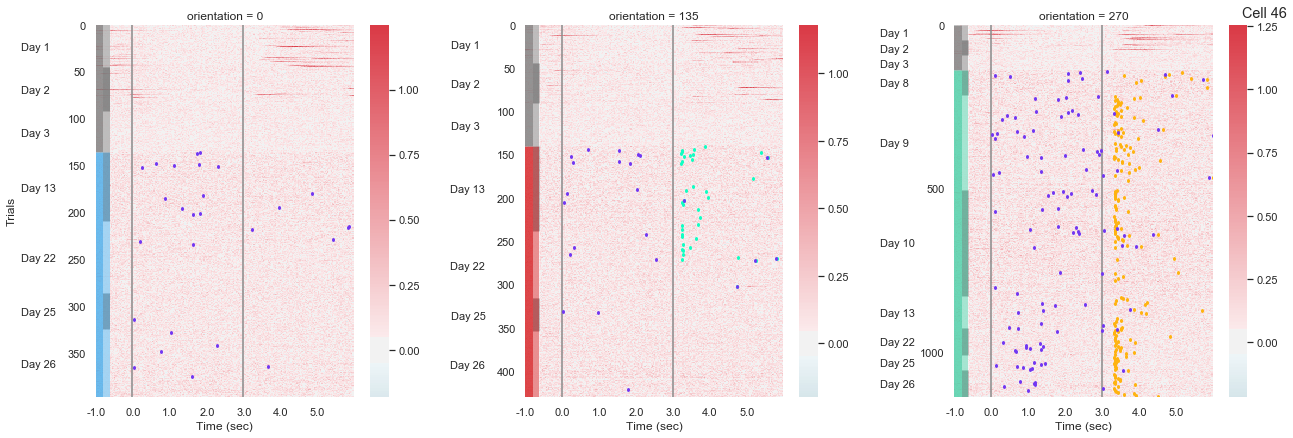

In [29]:
# baseline subtraction seems off
# housekeeping for naive metadata
# auto scaling of cdata

run_line = False
day_line = False
cs_bar = True
day_bar = True
cell = 46
# arthur's predetermined hex colors 
colors = {
    'orange': '#E86E0A',
    'red': '#D61E21',
    'gray': '#7C7C7C',
    'black': '#000000',
    'green': '#75D977',
    'mint': '#47D1A8',
    'purple': '#C880D1',
    'indigo': '#5E5AE6',
    'blue': '#47AEED', # previously 4087DD
    'yellow': '#F2E205',
}

# cs to color mapping 
cs_colors = {
    'plus': 'mint',
    'minus': 'red',
    'neutral': 'blue',
    'pavlovian': 'mint',
    'naive': 'gray'
}

# day_colors = {
#     'Ared1': ['#E6B0AA', '#D98880', '#CD6155', '#C0392B', '#A93226'],
#     'Bred2': ['#F5B7B1', '#F1948A', '#EC7063', '#E74C3C', '#CB4335'],
#     'Cpurple3': ['#D7BDE2', '#C39BD3', '#AF7AC5', '#9B59B6', '#884EA0'],
#     'Dpurple4': ['#D2B4DE', '#BB8FCE', '#A569BD', '#8E44AD', '#7D3C98'],
#     'Eblue5': ['#A9CCE3', '#7FB3D5', '#5499C7', '#2980B9', '#2471A3'],
#     'Fblue6': ['#AED6F1', '#85C1E9', '#5DADE2', '#3498DB', '#2E86C1'],
#     'Ggreen7': ['#A3E4D7', '#76D7C4', '#48C9B0', '#1ABC9C', '#17A589'],
#     'Hgreen8': ['#A2D9CE', '#73C6B6', '#45B39D', '#16A085', '#138D75'],
#     'Igreen9': ['#A9DFBF', '#7DCEA0', '#52BE80', '#27AE60', '#229954'],
#     'Jgreen10': ['#ABEBC6', '#82E0AA', '#58D68D', '#2ECC71', '#28B463'],
#     'Kyellow11': ['#F9E79F', '#F7DC6F', '#F4D03F', '#F1C40F', '#D4AC0D'],
#     'Lorange12': ['#FAD7A0', '#F8C471', '#F5B041', '#F39C12', '#D68910'],
#     'Morange13': ['#F5CBA7', '#F0B27A', '#EB984E', '#E67E22', '#CA6F1E'],
#     'Norange14': ['#EDBB99', '#E59866', '#DC7633', '#D35400', '#BA4A00', '#A04000'],
#       'grey': ['#D6DBDF', '#AEB6BF', '#85929E', '#5D6D7E', '#34495E']
# }

# day_colors = {
#      'Abeige': ['#a77676', '#b28887', '#bd9998', '#c8aaa9', '#d3bbba'],
#      'Bgrey': ['#D6DBDF', '#AEB6BF', '#85929E', '#5D6D7E', '#34495E'][::-1]
# }
day_colors = {
     'A': '#FDFEFE',
     'B': '#7B7D7D'
}
# red=high, white=middle, blue=low colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# get timestamp info for plotting lines
times = df['timestamp']
zero_sec = np.where(np.unique(times) >= 0)[0][0]
three_sec = np.where(np.unique(times) >= 3)[0][0]

# oris
oris = np.array([0, 135, 270])

# plot main figure
# full_trace = df['trace']
# full_trace[full_trace < 10]
# vmax = np.nanmax(full_trace[full_trace < 10])
# vmin = np.nanmin(full_trace[full_trace > -10])
toplot = df.pivot_table(index=['date', 'run','trial_idx','orientation'] , columns=['timestamp'], values='trace')
g = sns.FacetGrid(toplot.reset_index('orientation'), col='orientation', height=6, sharey=False, dropna=False)
g.map_dataframe(myheatmap, center=0, xticklabels=31, cmap=cmap)  
g.fig.suptitle('Cell ' + str(cell), x=0.98)

# loop through axes and plot relevant metadata on top
count = 0
# cmax = []
# cmin = []
for ax in g.axes[0]:
    
    # get metadata for this orientation/set of trials
    meta = df.loc[df['orientation'] == oris[count], ['condition', 'ensure', 'quinine', 'firstlick', 'run_type']]
    meta = meta.reset_index()
    meta = meta.drop_duplicates()
    ensure = np.array(meta['ensure'])
    quinine = np.array(meta['quinine'])
    firstlick = np.array(meta['firstlick'])
    css = meta['condition']
    run_type = meta['run_type']
    
    
    
    ori_inds = np.array(toplot.index.get_level_values('orientation'))
    ori_inds = ori_inds == oris[count]

    # set labels
    if count == 0:
        ax.set_ylabel('Trials')
    ax.set_xlabel('Time (sec)')
    
    # get automatic vmin/vmax
#     cmin.append(ax.collections[0].colorbar.vmin)
#     cmax.append(ax.collections[0].colorbar.vmin)
    
    # plot cs color bar/line
    if cs_bar:
        css[run_type == 'naive'] = 'naive'
        for cs in np.unique(css):
            cs_line_color = colors[cs_colors[cs]]
            cs_y = np.where(css == cs)[0]
            cs_y = [cs_y[0]-0.5, cs_y[-1]+0.5]
            ax.plot((5, 5), cs_y, color=cs_line_color, ls='-', lw=15, alpha=0.8, solid_capstyle='butt')
    
    # find days where learning or reversal start
#     if day_bar:
#         days = np.array(toplot.index.get_level_values('date'))
#         days = days[ori_inds]
#         runs = np.array(toplot.index.get_level_values('run'))
#         runs = runs[ori_inds]
#         count_d = 0
#         for day in np.unique(days):
#             day_runs = runs[days == day]
#             count_r = 0
#             for run in np.unique(day_runs):
#                 day_y = np.where((days == day) & (runs == run))[0]
#                 day_y = [day_y[0]-0.5, day_y[-1]+0.5]
#                 try:
#                     day_bar_color = day_colors[sorted(day_colors.keys())[count_d]][count_r]
#                 except:
#                     count_d = 0
#                     day_bar_color = day_colors[sorted(day_colors.keys())[count_d]][count_r]
                    
#                 ax.plot((11.5, 11.5), day_y, color=day_bar_color, ls='-', lw=9, alpha=0.8, solid_capstyle='butt')
                
#                 count_r = count_r + 1
#             count_d = count_d + 1
            
    # find days where learning or reversal start
    if day_bar:
        days = np.array(toplot.index.get_level_values('date'))
        days = days[ori_inds]
        runs = np.array(toplot.index.get_level_values('run'))
        runs = runs[ori_inds]
        count_d = 0
        for day in np.unique(days):
            day_y = np.where(days == day)[0]
            day_y = [day_y[0]-0.5, day_y[-1]+0.5]
#             if count_d%2 == 1:
            day_bar_color = day_colors[sorted(day_colors.keys())[count_d%2]]       
            ax.plot((9, 9), day_y, color=day_bar_color, ls='-', lw=7, alpha=0.4, solid_capstyle='butt')
            count_d = count_d + 1
            
    # consider doing this with a colorbar rather than lines
    # could do hsv colors for days and shades therein for runs
    # plot lines between days
    if day_line:
        days = np.array(toplot.index.get_level_values('date'))
        days = days[ori_inds]
        days = np.diff(days)
        day_ind = np.where(days > 0)[0]
        for y in day_ind:
            day_y = [y, y]
            ax.plot(x_lim, day_y, color='#8e8e8e', ls='-', lw=2.5)
        
    # plot lines between runs
    if run_line:
        runs = np.array(toplot.index.get_level_values('run'))
        runs = runs[ori_inds]
        runs = np.diff(runs)
        run_ind = np.where(runs > 0)[0]
        for y in run_ind:
            run_y = [y, y]
            ax.plot(x_lim, run_y, color='#bababa', ls='-', lw=2.5)
    
    # plot onset/offest lines
    y_lim = ax.get_ylim()
    x_lim = ax.get_xlim()
    ax.plot((zero_sec, zero_sec), y_lim, color='#8e8e8e', ls='-', lw=2, alpha=0.8)
    ax.plot((three_sec, three_sec), y_lim, color='#8e8e8e', ls='-', lw=2, alpha=0.8)
    
    # plot quinine
    for l in range(len(quinine)):
        if np.isfinite(quinine[l]):
            x = [quinine[l], quinine[l]]
            y = [l-0.5, l+0.5]
            ax.plot(x, y, color='#0fffc3', ls='-', lw=3)
            
    # plot ensure
#     print(toplot.head())
#     teste = toplot['ensure'].values
#     teste = teste[ori_inds]
#     print(len(teste))
#     print(y_lim)
    for l in range(len(ensure)):
        if np.isfinite(ensure[l]):
            x = [ensure[l], ensure[l]]
            y = [l-0.5, l+0.5]
            ax.plot(x, y, color='#ffb30f', ls='-', lw=3)
            
    # plot licks
    for l in range(len(firstlick)):
        if np.isfinite(firstlick[l]):
            x = [firstlick[l], firstlick[l]]
            y = [l-0.25, l+0.25]
            ax.plot(x, y, color='#7237f2', ls='-', lw=3)
    
#     print(len(ensure))
#     print(len(firstlick))
#     print(y_lim)
    
    # reset ylabels
    if y_lim[0] < 100:
        step = 10
    elif y_lim[0] < 200:
        step = 20
    elif y_lim[0] < 500:
        step = 50
    elif y_lim[0] < 5000:
        step = 500
    elif y_lim[0] < 10000:
        step = 1000
    elif y_lim[0] >= 10000:
        step = 5000
    base_yticks = range(int(y_lim[-1]), int(y_lim[0]), int(step))
    base_yticks = [s for s in base_yticks]
    base_ylabels = [str(s) for s in base_yticks]
    
    dates = np.array(toplot.index.get_level_values('date'))
    dates = dates[ori_inds]
    print(len(dates))
    print((y_lim))
    date_yticks = []
    date_label = []
    
    date_rel = flow.DateSorter.frommeta(mice=[mouse])
    date_rel = [s.date for s in date_rel]
    
    for day in np.unique(dates):
        
        # find number of inds needed to shift labels to put in middle of date block
        last_ind = np.where(dates == day)[0][-1]
        first_ind = np.where(dates == day)[0][0]
        shifter = np.round((last_ind - first_ind)/2)
        label_ind = last_ind - shifter
        
        # get your relative day number 
        day_val = np.where(date_rel == day)[0][0] + 1  # add one to make it one-indexed
        
        # add a pad to keep labels left-justified 
        if day_val < 10:
            pad = '  '
        else:
            pad = ''
            
        # if the date label and trial label inds are exactly the same
        # force the label info onto one line of text
        # label days with imaging day number 
        if np.isin(label_ind, base_yticks):
            # remove the existing ind and add a special label to end
            print(base_yticks)
            print(np.isin(base_yticks, label_ind))
#             base_yticks = base_yticks[np.isin(base_yticks, label_ind)]
            base_yticks = [base_yticks[s] for s in range(len(base_yticks)) if ~np.isin(base_yticks, label_ind)[s]]
            print(base_yticks)
            break
            base_ylabels.append('Day ' + str(day_val) + '          ' + str(label_ind))
        else:
            base_ylabels.append('Day ' + str(day_val) + '          ' + pad)
        base_yticks.append(label_ind) 
            
    ax.set_yticks(base_yticks)
    ax.set_yticklabels(base_ylabels)
    
    count = count + 1

# match vmin and max across plots
# cmin = np.nanmin(cmin)
# cmax = np.nanmax(cmax)

# for ax in g.axes[0]:
#     ax.collections[0].colorbar.vmin = cmin
#     ax.collections[0].colorbar.vmax = cmax

In [18]:
### NUMBER 2
# baseline subtraction seems off
# housekeeping for naive metadata
# auto scaling of cdata

run_line = False
day_line = False
cs_bar = True
day_bar = True
cell = 10
# arthur's predetermined hex colors 
colors = {
    'orange': '#E86E0A',
    'red': '#D61E21',
    'gray': '#7C7C7C',
    'black': '#000000',
    'green': '#75D977',
    'mint': '#47D1A8',
    'purple': '#C880D1',
    'indigo': '#5E5AE6',
    'blue': '#47AEED', # previously 4087DD
    'yellow': '#F2E205',
}

# cs to color mapping 
cs_colors = {
    'plus': 'mint',
    'minus': 'red',
    'neutral': 'blue',
    'pavlovian': 'mint',
    'naive': 'gray'
}

# day_colors = {
#     'Ared1': ['#E6B0AA', '#D98880', '#CD6155', '#C0392B', '#A93226'],
#     'Bred2': ['#F5B7B1', '#F1948A', '#EC7063', '#E74C3C', '#CB4335'],
#     'Cpurple3': ['#D7BDE2', '#C39BD3', '#AF7AC5', '#9B59B6', '#884EA0'],
#     'Dpurple4': ['#D2B4DE', '#BB8FCE', '#A569BD', '#8E44AD', '#7D3C98'],
#     'Eblue5': ['#A9CCE3', '#7FB3D5', '#5499C7', '#2980B9', '#2471A3'],
#     'Fblue6': ['#AED6F1', '#85C1E9', '#5DADE2', '#3498DB', '#2E86C1'],
#     'Ggreen7': ['#A3E4D7', '#76D7C4', '#48C9B0', '#1ABC9C', '#17A589'],
#     'Hgreen8': ['#A2D9CE', '#73C6B6', '#45B39D', '#16A085', '#138D75'],
#     'Igreen9': ['#A9DFBF', '#7DCEA0', '#52BE80', '#27AE60', '#229954'],
#     'Jgreen10': ['#ABEBC6', '#82E0AA', '#58D68D', '#2ECC71', '#28B463'],
#     'Kyellow11': ['#F9E79F', '#F7DC6F', '#F4D03F', '#F1C40F', '#D4AC0D'],
#     'Lorange12': ['#FAD7A0', '#F8C471', '#F5B041', '#F39C12', '#D68910'],
#     'Morange13': ['#F5CBA7', '#F0B27A', '#EB984E', '#E67E22', '#CA6F1E'],
#     'Norange14': ['#EDBB99', '#E59866', '#DC7633', '#D35400', '#BA4A00', '#A04000'],
#       'grey': ['#D6DBDF', '#AEB6BF', '#85929E', '#5D6D7E', '#34495E']
# }

# day_colors = {
#      'Abeige': ['#a77676', '#b28887', '#bd9998', '#c8aaa9', '#d3bbba'],
#      'Bgrey': ['#D6DBDF', '#AEB6BF', '#85929E', '#5D6D7E', '#34495E'][::-1]
# }
day_colors = {
     'A': '#FDFEFE',
     'B': '#7B7D7D'
}
# red=high, white=middle, blue=low colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# get timestamp info for plotting lines
times = df['timestamp']
zero_sec = np.where(np.unique(times) >= 0)[0][0]
three_sec = np.where(np.unique(times) >= 3)[0][0]

# oris
oris = np.array([0, 135, 270])

# plot main figure
# full_trace = df['trace']
# full_trace[full_trace < 10]
# vmax = np.nanmax(full_trace[full_trace < 10])
# vmin = np.nanmin(full_trace[full_trace > -10])
toplot = df.pivot_table(index=['date', 'run','trial_idx'] , columns=['orientation','timestamp'], values='trace')
print(toplot.head())
g = sns.FacetGrid(toplot, col='orientation', height=6, sharey=False, )
g.map_dataframe(myheatmap, center=0, xticklabels=31, cmap=cmap)  
g.fig.suptitle('Cell ' + str(cell), x=0.98)

# loop through axes and plot relevant metadata on top
count = 0
# cmax = []
# cmin = []
for ax in g.axes[0]:
    
    # get metadata for this orientation/set of trials
    meta = df.loc[df['orientation'] == oris[count], ['condition', 'ensure', 'quinine', 'firstlick', 'run_type']]
    meta = meta.reset_index()
    meta = meta.drop_duplicates()
    ensure = np.array(meta['ensure'])
    quinine = np.array(meta['quinine'])
    firstlick = np.array(meta['firstlick'])
    css = meta['condition']
    run_type = meta['run_type']
    
    
    
    ori_inds = np.array(toplot.index.get_level_values('orientation'))
    ori_inds = ori_inds == oris[count]

    # set labels
    if count == 0:
        ax.set_ylabel('Trials')
    ax.set_xlabel('Time (sec)')
    
    # get automatic vmin/vmax
#     cmin.append(ax.collections[0].colorbar.vmin)
#     cmax.append(ax.collections[0].colorbar.vmin)
    
    # plot cs color bar/line
    if cs_bar:
        css[run_type == 'naive'] = 'naive'
        for cs in np.unique(css):
            cs_line_color = colors[cs_colors[cs]]
            cs_y = np.where(css == cs)[0]
            cs_y = [cs_y[0]-0.5, cs_y[-1]+0.5]
            ax.plot((5, 5), cs_y, color=cs_line_color, ls='-', lw=15, alpha=0.8, solid_capstyle='butt')
    
    # find days where learning or reversal start
#     if day_bar:
#         days = np.array(toplot.index.get_level_values('date'))
#         days = days[ori_inds]
#         runs = np.array(toplot.index.get_level_values('run'))
#         runs = runs[ori_inds]
#         count_d = 0
#         for day in np.unique(days):
#             day_runs = runs[days == day]
#             count_r = 0
#             for run in np.unique(day_runs):
#                 day_y = np.where((days == day) & (runs == run))[0]
#                 day_y = [day_y[0]-0.5, day_y[-1]+0.5]
#                 try:
#                     day_bar_color = day_colors[sorted(day_colors.keys())[count_d]][count_r]
#                 except:
#                     count_d = 0
#                     day_bar_color = day_colors[sorted(day_colors.keys())[count_d]][count_r]
                    
#                 ax.plot((11.5, 11.5), day_y, color=day_bar_color, ls='-', lw=9, alpha=0.8, solid_capstyle='butt')
                
#                 count_r = count_r + 1
#             count_d = count_d + 1
            
    # find days where learning or reversal start
    if day_bar:
        days = np.array(toplot.index.get_level_values('date'))
        days = days[ori_inds]
        runs = np.array(toplot.index.get_level_values('run'))
        runs = runs[ori_inds]
        count_d = 0
        for day in np.unique(days):
            day_y = np.where(days == day)[0]
            day_y = [day_y[0]-0.5, day_y[-1]+0.5]
#             if count_d%2 == 1:
            day_bar_color = day_colors[sorted(day_colors.keys())[count_d%2]]       
            ax.plot((9, 9), day_y, color=day_bar_color, ls='-', lw=7, alpha=0.4, solid_capstyle='butt')
            count_d = count_d + 1
            
    # consider doing this with a colorbar rather than lines
    # could do hsv colors for days and shades therein for runs
    # plot lines between days
    if day_line:
        days = np.array(toplot.index.get_level_values('date'))
        days = days[ori_inds]
        days = np.diff(days)
        day_ind = np.where(days > 0)[0]
        for y in day_ind:
            day_y = [y, y]
            ax.plot(x_lim, day_y, color='#8e8e8e', ls='-', lw=2.5)
        
    # plot lines between runs
    if run_line:
        runs = np.array(toplot.index.get_level_values('run'))
        runs = runs[ori_inds]
        runs = np.diff(runs)
        run_ind = np.where(runs > 0)[0]
        for y in run_ind:
            run_y = [y, y]
            ax.plot(x_lim, run_y, color='#bababa', ls='-', lw=2.5)
    
    # plot onset/offest lines
    y_lim = ax.get_ylim()
    x_lim = ax.get_xlim()
    ax.plot((zero_sec, zero_sec), y_lim, color='#8e8e8e', ls='-', lw=2, alpha=0.8)
    ax.plot((three_sec, three_sec), y_lim, color='#8e8e8e', ls='-', lw=2, alpha=0.8)
    
    # plot quinine
    for l in range(len(quinine)):
        if np.isfinite(quinine[l]):
            x = [quinine[l], quinine[l]]
            y = [l-0.5, l+0.5]
            ax.plot(x, y, color='#0fffc3', ls='-', lw=3)
            
    # plot ensure
    print(toplot.head())
#     teste = toplot['ensure'].values
#     teste = teste[ori_inds]
#     print(len(teste))
#     print(y_lim)
    for l in range(len(ensure)):
        if np.isfinite(ensure[l]):
            x = [ensure[l], ensure[l]]
            y = [l-0.5, l+0.5]
            ax.plot(x, y, color='#ffb30f', ls='-', lw=3)
            
    # plot licks
    for l in range(len(firstlick)):
        if np.isfinite(firstlick[l]):
            x = [firstlick[l], firstlick[l]]
            y = [l-0.5, l+0.5]
            ax.plot(x, y, color='#7237f2', ls='-', lw=3)
    
#     print(len(ensure))
#     print(len(firstlick))
#     print(y_lim)
    
    # reset ylabels
    if y_lim[0] < 100:
        step = 10
    elif y_lim[0] < 200:
        step = 20
    elif y_lim[0] < 500:
        step = 50
    elif y_lim[0] < 5000:
        step = 500
    elif y_lim[0] < 10000:
        step = 1000
    elif y_lim[0] >= 10000:
        step = 5000
    base_yticks = range(int(y_lim[-1]), int(y_lim[0]), int(step))
    base_yticks = [s for s in base_yticks]
    base_ylabels = [str(s) for s in base_yticks]
    
    dates = np.array(toplot.index.get_level_values('date'))
    dates = dates[ori_inds]
    print(len(dates))
    print((y_lim))
    date_yticks = []
    date_label = []
    
    date_rel = flow.DateSorter.frommeta(mice=[mouse])
    date_rel = [s.date for s in date_rel]
    
    for day in np.unique(dates):
        
        # find number of inds needed to shift labels to put in middle of date block
        last_ind = np.where(dates == day)[0][-1]
        first_ind = np.where(dates == day)[0][0]
        shifter = np.round((last_ind - first_ind)/2)
        label_ind = last_ind - shifter
        
        # get your relative day number 
        day_val = np.where(date_rel == day)[0][0] + 1  # add one to make it one-indexed
        
        # add a pad to keep labels left-justified 
        if day_val < 10:
            pad = '  '
        else:
            pad = ''
            
        # if the date label and trial label inds are exactly the same
        # force the label info onto one line of text
        # label days with imaging day number 
        if np.isin(label_ind, base_yticks):
            # remove the existing ind and add a special label to end
            print(base_yticks)
            print(np.isin(base_yticks, label_ind))
#             base_yticks = base_yticks[np.isin(base_yticks, label_ind)]
            base_yticks = [base_yticks[s] for s in range(len(base_yticks)) if ~np.isin(base_yticks, label_ind)[s]]
            print(base_yticks)
            break
            base_ylabels.append('Day ' + str(day_val) + '          ' + str(label_ind))
        else:
            base_ylabels.append('Day ' + str(day_val) + '          ' + pad)
        base_yticks.append(label_ind) 
            
    ax.set_yticks(base_yticks)
    ax.set_yticklabels(base_ylabels)
    
    count = count + 1

# match vmin and max across plots
# cmin = np.nanmin(cmin)
# cmax = np.nanmax(cmax)

# for ax in g.axes[0]:
#     ax.collections[0].colorbar.vmin = cmin
#     ax.collections[0].colorbar.vmax = cmax

orientation                0                                            \
timestamp            -1.000000 -0.967742 -0.935484 -0.903226 -0.870968   
date   run trial_idx                                                     
170116 3   0          0.056848  0.052127  0.234295  0.055797  0.066831   
           1               NaN       NaN       NaN       NaN       NaN   
           2               NaN       NaN       NaN       NaN       NaN   
           3          0.050118  0.131874  0.094617  0.132817  0.055466   
           4               NaN       NaN       NaN       NaN       NaN   

orientation                                                             \
timestamp            -0.838710 -0.806452 -0.774194 -0.741935 -0.709677   
date   run trial_idx                                                     
170116 3   0          0.228354  0.117453  0.137114  0.116576  0.130322   
           1               NaN       NaN       NaN       NaN       NaN   
           2               NaN       

KeyError: 'orientation'

In [25]:
 ax.collections[0].colorbar.vmin = -1

AttributeError: 'function' object has no attribute 'vmin'

In [12]:
def myheatmap(data, **kwargs):
    
#     print(data.head())
    mydata = data.set_index('orientation', append=True)
#     print(mydata.head())
    sns.heatmap(mydata, **kwargs)

In [77]:
# use runtype to make a housekeeping function that makes sure that naive is matched to learning
# force all non-orimapping presentations of plus to be plus (even if they are pavlovian) since no reward is occuring

# def trailmeta_housekeeping(trial_meta_df)

print(day_colors.keys()[0])

red1


In [46]:
days = flow.DateSorter.frommeta(mice=[mouse])

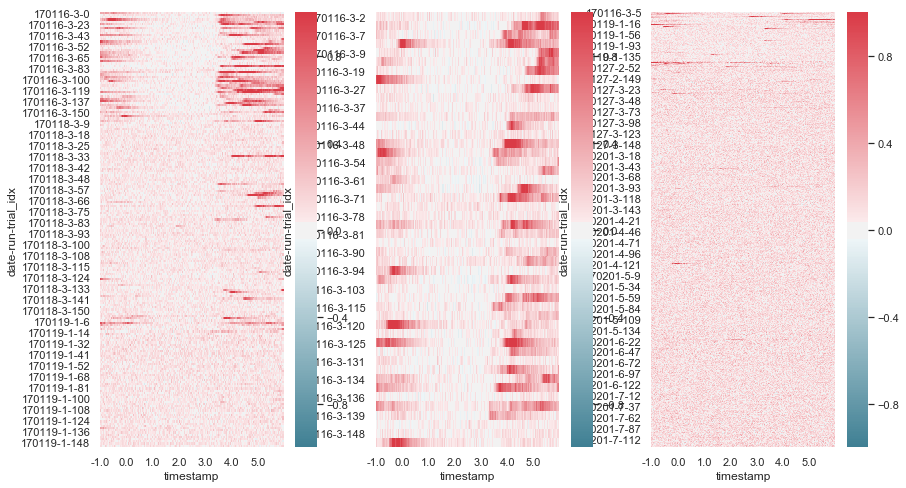

In [136]:
fig, ax = plt.subplots(1,3,figsize=(14,8))

# plotting parameters 
center = 0
vmin = -1
vmax = 1
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# slice datasets into orientations 0, 135, 270
df0 = df1.loc[(df1.orientation == 0),:]
df0 = df0.pivot_table(index=['date', 'run','trial_idx'] , columns='timestamp', values='trace')
df135 = df1.loc[(df1.orientation == 135),:]
df135 = df135.pivot_table(index=['date', 'run','trial_idx'] , columns='timestamp', values='trace')
df270 = df1.loc[(df1.orientation == 270),:]
df270 = df270.pivot_table(index=['date', 'run','trial_idx'] , columns='timestamp', values='trace')

# to plot with nans there is probably some pandas rehspe of the dataframe that will fill in 
# non overlapping values with nans

# plot heatmaps 
sns.heatmap(df0, xticklabels=31, ax=ax[0], vmax=vmax, vmin=vmin, center=center, cmap=cmap)
sns.heatmap(df135, xticklabels=31, ax=ax[1], vmax=vmax, vmin=vmin, center=center, cmap=cmap)
sns.heatmap(df270, xticklabels=31, ax=ax[2], vmax=vmax, vmin=vmin, center=center, cmap=cmap)